# 4. Coarse Dimensions Demonstration

This notebook demonstrates the expanded GRI scorecard with coarser-grained dimensions for broader representativeness analysis.

## Overview

The **expanded GRI scorecard** now includes both fine-grained and coarse-grained dimensions:

### Fine-grained (Original)
- Country × Gender × Age
- Country × Religion  
- Country × Environment

### Coarse-grained (New)
- **Country**: Country-level representativeness
- **Region**: Regional representativeness (UN M49 regions)
- **Continent**: Continental representativeness
- **Gender**: Global gender representativeness
- **Age Group**: Global age representativeness
- **Religion**: Global religious representativeness
- **Environment**: Global urban/rural representativeness

**Why coarser dimensions matter:**
- Provide different perspectives on representativeness
- Help identify geographic vs. demographic imbalances
- Useful for different analysis goals and reporting needs

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add gri module to path
sys.path.append('..')
from gri import calculate_gri_scorecard, get_config, load_data

# Set plotting style
plt.style.use('default')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

## 1. Configuration Overview

In [2]:
# Load configuration to show expanded scorecard
config = get_config()

print("EXPANDED STANDARD GRI SCORECARD")
print("=" * 50)
print(f"Total dimensions: {len(config.get_standard_scorecard())}")
print()

for i, dim in enumerate(config.get_standard_scorecard(), 1):
    print(f"{i:2d}. {dim['name']}")
    print(f"    Columns: {dim['columns']}")
    print(f"    Type: {dim['description']}")
    if 'requires_mapping' in dim:
        print(f"    Requires: {dim['requires_mapping']}")
    print()

EXPANDED STANDARD GRI SCORECARD
Total dimensions: 13

 1. Country × Gender × Age
    Columns: ['country', 'gender', 'age_group']
    Type: Fine-grained demographic representativeness

 2. Country × Religion
    Columns: ['country', 'religion']
    Type: Religious representativeness by country

 3. Country × Environment
    Columns: ['country', 'environment']
    Type: Urban/rural representativeness by country

 4. Country
    Columns: ['country']
    Type: Country-level representativeness

 5. Region × Gender × Age
    Columns: ['region', 'gender', 'age_group']
    Type: Regional demographic representativeness
    Requires: ['country_to_region']

 6. Region × Religion
    Columns: ['region', 'religion']
    Type: Regional religious representativeness
    Requires: ['country_to_region']

 7. Region × Environment
    Columns: ['region', 'environment']
    Type: Regional urban/rural representativeness
    Requires: ['country_to_region']

 8. Region
    Columns: ['region']
    Type: Region

## 2. Create Sample Data with Full Coverage

In [3]:
# Create comprehensive sample data
np.random.seed(42)
n_participants = 1000

# Include diverse countries from different regions
countries = [
    'United States', 'Canada',  # North America
    'Brazil', 'Argentina',      # South America  
    'Germany', 'France', 'Spain', 'Poland',  # Europe
    'Nigeria', 'South Africa', 'Egypt',      # Africa
    'India', 'China', 'Japan', 'Indonesia',  # Asia
    'Australia'                 # Oceania
]

sample_survey = pd.DataFrame({
    'country': np.random.choice(countries, n_participants),
    'gender': np.random.choice(['Male', 'Female'], n_participants), 
    'age_group': np.random.choice([
        '18-25', '26-35', '36-45', '46-55', '56-65', '65+'
    ], n_participants),
    'religion': np.random.choice([
        'Christianity', 'Islam', 'Hinduism', 'Buddhism', 
        'Judaism', 'I do not identify with any religious group or faith',
        'Other religious group'
    ], n_participants),
    'environment': np.random.choice(['Urban', 'Rural'], n_participants)
})

print(f"Sample survey: {len(sample_survey):,} participants")
print(f"Countries: {sample_survey['country'].nunique()}")
print(f"Unique countries: {sorted(sample_survey['country'].unique())}")
print()
print("Sample composition:")
print(f"- Gender: {dict(sample_survey['gender'].value_counts())}")
print(f"- Environment: {dict(sample_survey['environment'].value_counts())}")

Sample survey: 1,000 participants
Countries: 16
Unique countries: ['Argentina', 'Australia', 'Brazil', 'Canada', 'China', 'Egypt', 'France', 'Germany', 'India', 'Indonesia', 'Japan', 'Nigeria', 'Poland', 'South Africa', 'Spain', 'United States']

Sample composition:
- Gender: {'Male': np.int64(526), 'Female': np.int64(474)}
- Environment: {'Urban': np.int64(524), 'Rural': np.int64(476)}


## 3. Load Benchmark Data

In [4]:
# Load all benchmark datasets
benchmark_data = {
    'age_gender': load_data('../data/processed/benchmark_country_gender_age.csv'),
    'religion': load_data('../data/processed/benchmark_country_religion.csv'),
    'environment': load_data('../data/processed/benchmark_country_environment.csv')
}

print("Benchmark data loaded:")
for name, df in benchmark_data.items():
    print(f"- {name}: {len(df):,} strata, proportion sum = {df['population_proportion'].sum():.6f}")

Benchmark data loaded:
- age_gender: 2,699 strata, proportion sum = 1.000000
- religion: 1,654 strata, proportion sum = 1.000000
- environment: 509 strata, proportion sum = 1.000000


## 4. Calculate Expanded GRI Scorecard

In [5]:
# Calculate the full expanded scorecard
print("Calculating expanded GRI scorecard...")
scorecard = calculate_gri_scorecard(
    sample_survey,
    benchmark_data, 
    survey_source='global_dialogues',
    use_extended_dimensions=False  # Standard scorecard now includes coarser dimensions
)

print(f"\nCalculated {len(scorecard)-1} dimensions + average")
print("\nEXPANDED GRI SCORECARD RESULTS")
print("=" * 60)

# Display with formatting
display_df = scorecard.copy()
display_df['GRI Score'] = display_df['GRI Score'].round(4)
display_df['Diversity Score'] = display_df['Diversity Score'].round(4)

print(display_df[['Dimension', 'GRI Score', 'Diversity Score']].to_string(index=False))

Calculating expanded GRI scorecard...

Calculated 9 dimensions + average

EXPANDED GRI SCORECARD RESULTS
             Dimension  GRI Score  Diversity Score
Country × Gender × Age     0.0000           0.0000
    Country × Religion     0.0150           0.0385
 Country × Environment     0.0000           0.0000
               Country     0.0000           0.0000
 Region × Gender × Age     0.0570           0.0000
                Region     0.0570           0.0000
             Continent     0.0848           0.2000
             Age Group     0.8872           1.0000
                Gender     0.9805           1.0000
               AVERAGE     0.2313           0.2487


## 5. Analyze Dimension Categories

In [6]:
# Categorize dimensions by granularity
results_df = scorecard[scorecard['Dimension'] != 'AVERAGE'].copy()

# Categorize dimensions
def categorize_dimension(dim_name):
    if ' × ' in dim_name:
        if 'Country' in dim_name and len(dim_name.split(' × ')) >= 3:
            return 'Fine-grained (Country-based)'
        elif 'Region' in dim_name:
            return 'Medium-grained (Regional)'  
        else:
            return 'Medium-grained (Multi-factor)'
    else:
        if dim_name in ['Country', 'Region', 'Continent']:
            return 'Coarse-grained (Geographic)'
        else:
            return 'Coarse-grained (Demographic)'

results_df['Category'] = results_df['Dimension'].apply(categorize_dimension)

print("DIMENSIONS BY GRANULARITY")
print("=" * 40)
for category in results_df['Category'].unique():
    cat_data = results_df[results_df['Category'] == category]
    print(f"\n{category}:")
    for _, row in cat_data.iterrows():
        print(f"  • {row['Dimension']}: GRI={row['GRI Score']:.3f}, Diversity={row['Diversity Score']:.3f}")
    
    avg_gri = cat_data['GRI Score'].mean()
    avg_div = cat_data['Diversity Score'].mean()
    print(f"  → Category Average: GRI={avg_gri:.3f}, Diversity={avg_div:.3f}")

DIMENSIONS BY GRANULARITY

Fine-grained (Country-based):
  • Country × Gender × Age: GRI=0.000, Diversity=0.000
  → Category Average: GRI=0.000, Diversity=0.000

Medium-grained (Multi-factor):
  • Country × Religion: GRI=0.015, Diversity=0.038
  • Country × Environment: GRI=0.000, Diversity=0.000
  → Category Average: GRI=0.007, Diversity=0.019

Coarse-grained (Geographic):
  • Country: GRI=0.000, Diversity=0.000
  • Region: GRI=0.057, Diversity=0.000
  • Continent: GRI=0.085, Diversity=0.200
  → Category Average: GRI=0.047, Diversity=0.067

Medium-grained (Regional):
  • Region × Gender × Age: GRI=0.057, Diversity=0.000
  → Category Average: GRI=0.057, Diversity=0.000

Coarse-grained (Demographic):
  • Age Group: GRI=0.887, Diversity=1.000
  • Gender: GRI=0.981, Diversity=1.000
  → Category Average: GRI=0.934, Diversity=1.000


## 6. Visualize Results by Granularity

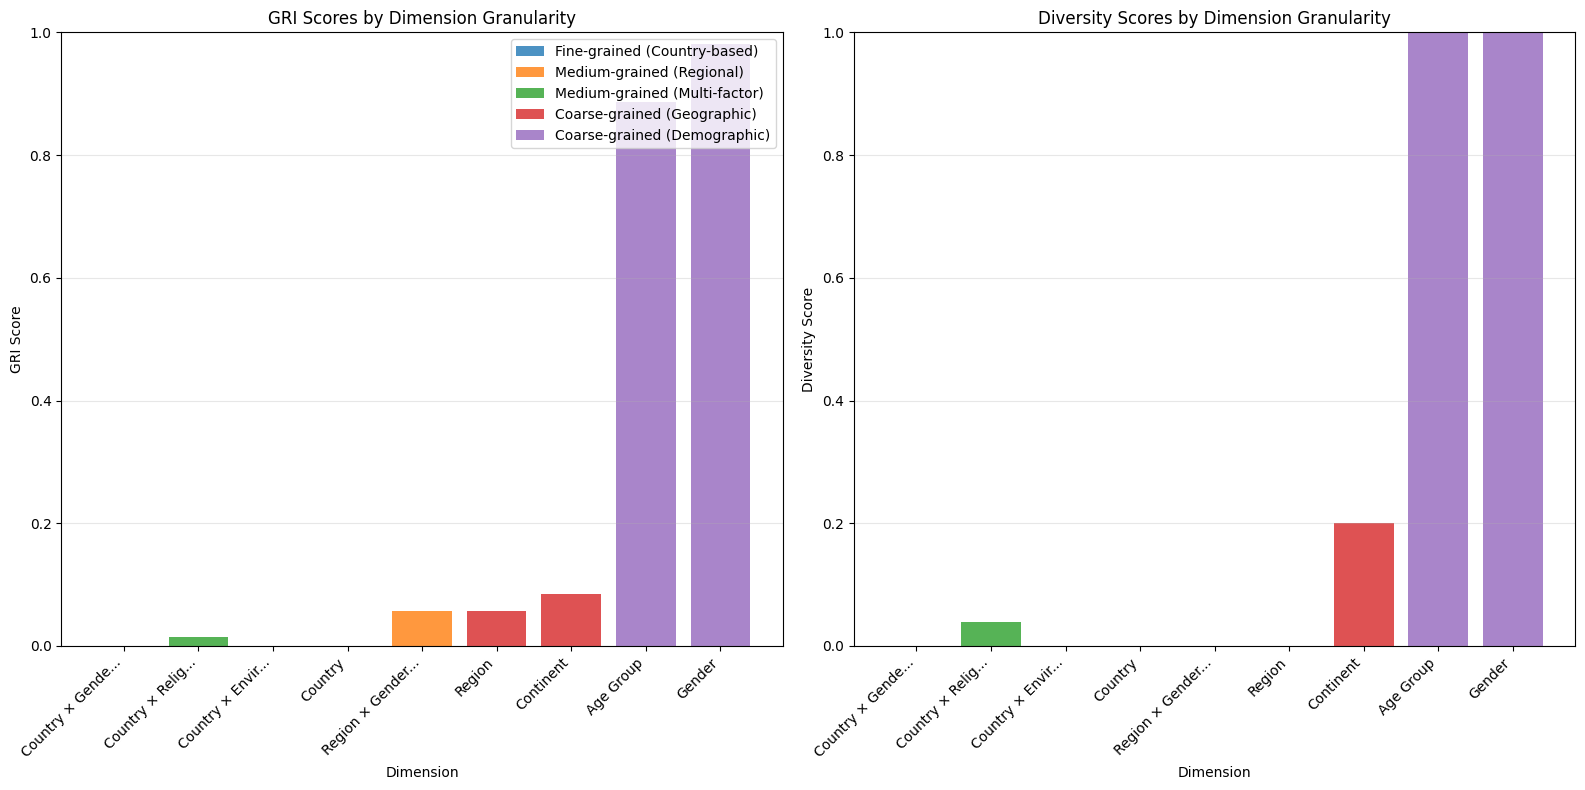

In [7]:
# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Color map for categories
category_colors = {
    'Fine-grained (Country-based)': '#1f77b4',
    'Medium-grained (Regional)': '#ff7f0e', 
    'Medium-grained (Multi-factor)': '#2ca02c',
    'Coarse-grained (Geographic)': '#d62728',
    'Coarse-grained (Demographic)': '#9467bd'
}

# GRI Scores
colors = [category_colors[cat] for cat in results_df['Category']]
bars1 = ax1.bar(range(len(results_df)), results_df['GRI Score'], color=colors, alpha=0.8)
ax1.set_xlabel('Dimension')
ax1.set_ylabel('GRI Score')
ax1.set_title('GRI Scores by Dimension Granularity')
ax1.set_xticks(range(len(results_df)))
ax1.set_xticklabels([d[:15] + '...' if len(d) > 15 else d for d in results_df['Dimension']], 
                    rotation=45, ha='right')
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)

# Diversity Scores
bars2 = ax2.bar(range(len(results_df)), results_df['Diversity Score'], color=colors, alpha=0.8)
ax2.set_xlabel('Dimension')
ax2.set_ylabel('Diversity Score')
ax2.set_title('Diversity Scores by Dimension Granularity')
ax2.set_xticks(range(len(results_df)))
ax2.set_xticklabels([d[:15] + '...' if len(d) > 15 else d for d in results_df['Dimension']], 
                    rotation=45, ha='right')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)

# Add legend
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, alpha=0.8, label=category) 
                  for category, color in category_colors.items()]
ax1.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

## 7. Insights from Coarse Dimensions

In [8]:
print("KEY INSIGHTS FROM COARSE DIMENSIONS")
print("=" * 50)

# Geographic analysis
geo_dims = results_df[results_df['Category'] == 'Coarse-grained (Geographic)']
if len(geo_dims) > 0:
    print("\n📍 GEOGRAPHIC REPRESENTATIVENESS:")
    for _, row in geo_dims.iterrows():
        gri_level = "High" if row['GRI Score'] > 0.6 else "Medium" if row['GRI Score'] > 0.3 else "Low"
        div_level = "High" if row['Diversity Score'] > 0.6 else "Medium" if row['Diversity Score'] > 0.3 else "Low"
        print(f"  • {row['Dimension']}: {gri_level} accuracy, {div_level} coverage")

# Demographic analysis  
demo_dims = results_df[results_df['Category'] == 'Coarse-grained (Demographic)']
if len(demo_dims) > 0:
    print("\n👥 DEMOGRAPHIC REPRESENTATIVENESS:")
    for _, row in demo_dims.iterrows():
        gri_level = "High" if row['GRI Score'] > 0.6 else "Medium" if row['GRI Score'] > 0.3 else "Low"
        div_level = "High" if row['Diversity Score'] > 0.6 else "Medium" if row['Diversity Score'] > 0.3 else "Low"
        print(f"  • {row['Dimension']}: {gri_level} accuracy, {div_level} coverage")

# Overall patterns
print("\n🔍 OVERALL PATTERNS:")
avg_by_category = results_df.groupby('Category')[['GRI Score', 'Diversity Score']].mean()
for category, scores in avg_by_category.iterrows():
    print(f"  • {category}: Avg GRI={scores['GRI Score']:.3f}, Avg Diversity={scores['Diversity Score']:.3f}")

print("\n💡 RECOMMENDATIONS:")
print("  • Use coarse dimensions to identify broad representativeness patterns")
print("  • Fine-grained dimensions reveal specific demographic gaps")
print("  • Regional analysis helps optimize geographic targeting")
print("  • Single demographic dimensions guide recruitment priorities")

KEY INSIGHTS FROM COARSE DIMENSIONS

📍 GEOGRAPHIC REPRESENTATIVENESS:
  • Country: Low accuracy, Low coverage
  • Region: Low accuracy, Low coverage
  • Continent: Low accuracy, Low coverage

👥 DEMOGRAPHIC REPRESENTATIVENESS:
  • Age Group: High accuracy, High coverage
  • Gender: High accuracy, High coverage

🔍 OVERALL PATTERNS:
  • Coarse-grained (Demographic): Avg GRI=0.934, Avg Diversity=1.000
  • Coarse-grained (Geographic): Avg GRI=0.047, Avg Diversity=0.067
  • Fine-grained (Country-based): Avg GRI=0.000, Avg Diversity=0.000
  • Medium-grained (Multi-factor): Avg GRI=0.007, Avg Diversity=0.019
  • Medium-grained (Regional): Avg GRI=0.057, Avg Diversity=0.000

💡 RECOMMENDATIONS:
  • Use coarse dimensions to identify broad representativeness patterns
  • Fine-grained dimensions reveal specific demographic gaps
  • Regional analysis helps optimize geographic targeting
  • Single demographic dimensions guide recruitment priorities


## Summary

This notebook demonstrated the **expanded GRI scorecard** with coarser-grained dimensions that provide:

### ✅ Enhanced Analysis Capabilities
- **Multi-level perspective**: Fine → Medium → Coarse granularity
- **Geographic hierarchy**: Country → Region → Continent
- **Demographic focus**: Individual demographic factors
- **Comprehensive coverage**: 13 standard dimensions

### ✅ Practical Benefits
- **Strategic insights**: Identify whether issues are geographic vs. demographic
- **Recruitment guidance**: Target specific countries, regions, or demographics
- **Progress tracking**: Monitor improvements at different granularities
- **Reporting flexibility**: Choose appropriate detail level for different audiences

### ✅ Configuration-Driven
- **Easy extension**: Add new dimensions via YAML configuration
- **Flexible mapping**: Support different survey formats and regional definitions
- **Backwards compatible**: Existing code continues to work

The expanded scorecard provides a comprehensive view of representativeness from multiple angles, enabling more nuanced analysis and targeted improvements to survey sampling strategies.